In [1]:
import os
import pandas as pd
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient
from dotenv import load_dotenv

# Obtendo as variáveis de ambiente principais e conectando ao serviço
load_dotenv()
ai_key = os.getenv("AI_KEY")
ai_endpoint = os.getenv("AI_ENDPOINT")

# Autenticação do cliente
try:       
    credential = AzureKeyCredential(ai_key)
    ai_client = TextAnalyticsClient(endpoint=ai_endpoint, credential=credential)
except Exception as ex:
    print("Erro na autenticação do cliente:", ex)
else:
    print("Cliente autenticado com sucesso.")

#carregando os dados
pasta_feedbacks = "./feedbacks/"

# Lista para armazenar feedbacks
feedbacks = []

# Percorrer todos os arquivos da pasta
for arquivo in os.listdir(pasta_feedbacks):
    if arquivo.endswith(".txt"): # considerando apenas arquivos de texto
        caminho = os.path.join(pasta_feedbacks, arquivo)
        with open(caminho, "r", encoding="utf-8") as f:
            texto = f.read().strip()
            feedbacks.append({"Arquivo": arquivo, "Feedback": texto})
# Criar DataFrame
df_feedbacks = pd.DataFrame(feedbacks)
df_feedbacks

Cliente autenticado com sucesso.


,Arquivo,Feedback
0,feedback1.txt,Comprei a Geladeira FrostMax 450L e em menos d...
1,feedback10.txt,"A Batedeira MixPro 500W é ok, faz bolos e mass..."
2,feedback2.txt,O Aspirador de Pó TurboClean 2000 perdeu a pot...
3,feedback3.txt,Adquiri o Micro-ondas HeatPro 32L e fiquei fru...
4,feedback4.txt,A Máquina de Lavar AquaWash 12kg consome muita...
5,feedback5.txt,O Liquidificador PowerBlend 900W quebrou a lâm...
6,feedback6.txt,Estou impressionado com a Lava-louças SmartDis...
7,feedback7.txt,A Cafeteira AromaExpress Digital prepara cafés...
8,feedback8.txt,Comprei o Ar-condicionado CoolBreeze Inverter ...
9,feedback9.txt,"O Ferro a Vapor SteamLine 2200W funciona bem, ..."


In [ ]:
{
    "Avaliacao": "positive",
    "confidence_scores": {
        "positive": 0.85,
        "neutral": 0.10,
        "negative": 0.05,
    }
}

In [7]:
def analisar_sentimentos(feedbacks):
    try:
        resultados = ai_client.analyze_sentiment(documents=feedbacks)
        sentimentos = []
        for resultado in resultados:
            # Para debug
            print(f"Resultado FINAL: {resultado}")
            print(f"Tipo: {type(resultado)}")

            if not resultado.is_error:
                scores = resultado.confidence_scores
                # Criar dicionario com os scores
                confs = {
                    "positive": scores.positive,
                    "neutral": scores.neutral,
                    "negative": scores.negative
                }
                # Pega o sentimento de maior confiança
                sentimento_mais_forte = max(confs, key=confs.get)
                sentimentos.append(sentimento_mais_forte)
            else:
                sentimentos.append("Erro")
        return sentimentos
    except Exception as ex:
        print("Erro ao analisar sentimentos:", ex)
        return ["Erro"] * len(feedbacks)

df_feedbacks["Sentimento_Associado"] =analisar_sentimentos(df_feedbacks["Feedback"].tolist())

Resultado FINAL: {'id': '0', 'sentiment': 'negative', 'warnings': [], 'statistics': None, 'confidence_scores': SentimentConfidenceScores(positive=0.01, neutral=0.14, negative=0.85), 'sentences': [SentenceSentiment(text=Comprei a Geladeira FrostMax 450L e em menos de três meses começou a fazer um ruído constante. , sentiment=negative, confidence_scores=SentimentConfidenceScores(positive=0.0, neutral=0.02, negative=0.97), length=95, offset=0, mined_opinions=[]), SentenceSentiment(text=Além disso, a porta não veda direito, o que compromete a conservação dos alimentos. , sentiment=negative, confidence_scores=SentimentConfidenceScores(positive=0.0, neutral=0.12, negative=0.87), length=84, offset=95, mined_opinions=[]), SentenceSentiment(text=A assistência técnica demorou muito para dar retorno., sentiment=negative, confidence_scores=SentimentConfidenceScores(positive=0.03, neutral=0.28, negative=0.69), length=53, offset=179, mined_opinions=[])], 'is_error': False, 'kind': 'SentimentAnalysis

In [ ]:
df_feedbacks[["Sentimento_Associado","Feedback"]]                                                           

,Sentimento_Associado,Feedback
0,negative,Comprei a Geladeira FrostMax 450L e em menos d...
1,negative,"A Batedeira MixPro 500W é ok, faz bolos e mass..."
2,negative,O Aspirador de Pó TurboClean 2000 perdeu a pot...
3,negative,Adquiri o Micro-ondas HeatPro 32L e fiquei fru...
4,negative,A Máquina de Lavar AquaWash 12kg consome muita...
5,positive,O Liquidificador PowerBlend 900W quebrou a lâm...
6,positive,Estou impressionado com a Lava-louças SmartDis...
7,positive,A Cafeteira AromaExpress Digital prepara cafés...
8,positive,Comprei o Ar-condicionado CoolBreeze Inverter ...
9,negative,"O Ferro a Vapor SteamLine 2200W funciona bem, ..."


In [14]:
df_feedbacks['Sentimento_Associado'].value_counts(normalize=True)*100

Sentimento_Associado
negative    60.0
positive    40.0
Name: proportion, dtype: float64

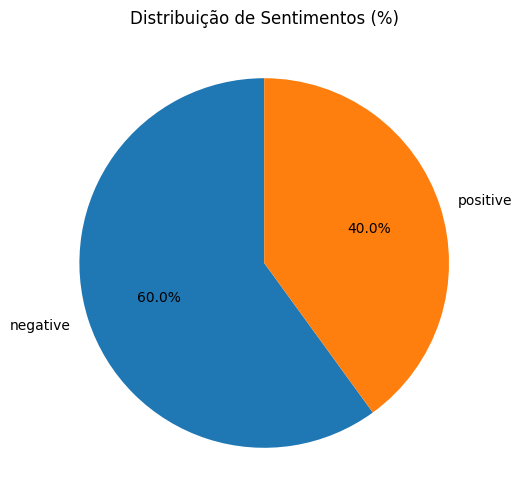

In [16]:
import matplotlib.pyplot as plt 

sentimento_counts = df_feedbacks['Sentimento_Associado'].value_counts(normalize=True)* 100

plt.figure(figsize=(6,6))
plt.pie(sentimento_counts,
        labels=sentimento_counts.index,
        autopct="%.1f%%",
        startangle=90)

plt.title("Distribuição de Sentimentos (%)")
plt.show()